# Sound source localization with a microphones array : beamforming approaches

You have characterized and analyzed the sound propagation in the previous practical. We will now
exploit theses properties to infer one sound source position w.r.t.\ a linear microphone array made
of $N=8$ omnidirectional MEMS microphones. The system you will be using is the same as before;
thus, most of the code you already wrote to acquire signals, plot them, etc.\ will remain the same.

In all the following, the acquisition system will work with a sampling frequency $F_s = 20$kHz, and with a buffer of size $\texttt{BLK} = 2048$.

In [1]:
# All required import
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from client import array
import time
from beamformer_etu import beamformer
import matplotlib.image as mpimg

In [2]:
#antenne=array('server') # When performing real-time acquisition
antenne=array('play')   # When playing recorded files

In [3]:
# Load acquisition and array parameters from the antenne variable, after launching acquisition or play
Fs = antenne.fs
BLK = antenne.blocksize
N = 8
d = antenne.interspace

### 1) To begin, start the acquisition of the audio system, and capture one audio buffer. Plot the resulting signals as a function of time.

In [4]:
# Read an audio buffer
m = antenne.read()
T_tot = len(m)/Fs # on calcul la durée totale de l'échantillon
vect_t= np.linspace(0,T_tot,len(m))  # on crée le vecteur de temps pour le plot

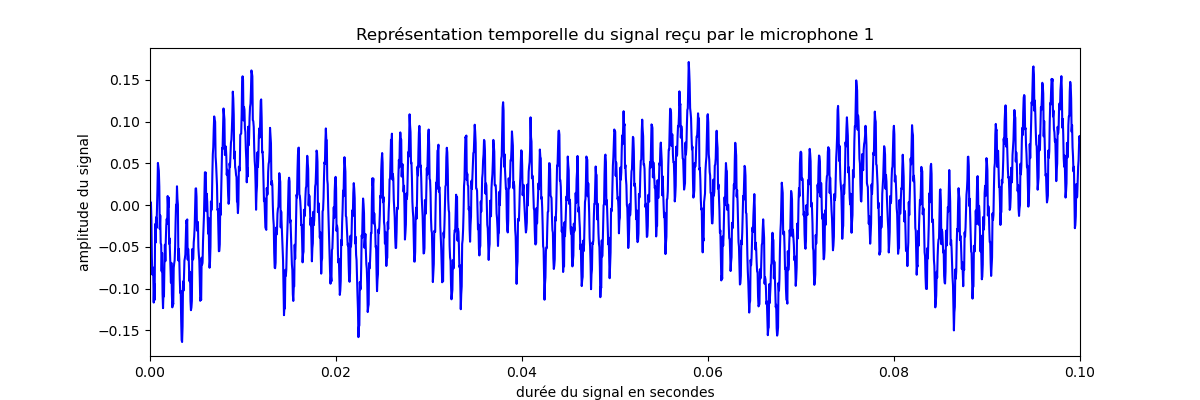

In [6]:
plt.clf()
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(vect_t, m[:, 0], color="blue", label='micro_1')
plt.xlabel('durée du signal en secondes')
plt.ylabel('amplitude du signal')
ax1.set_xlim([0, 0.1])
plt.title("Représentation temporelle du signal reçu par le microphone 1")

plt.show()

## 2.1/ Coding the beamformer filters and analyzing their properties

**These first questions have to be prepared before the practical session**

### 2) Write the position $z_n$ as a function of $n$ and interspace $d$. As a convention, the first microphone number is selected as $0$.

One can write :
$$z_n = (n-\frac{N-1}{2})*d$$ 
(si N=8)

### 3) Propose a function $\texttt{beam\_filter}$ returning the filter frequency response for one microphone number $\texttt{mic\_nb}$. 

In [7]:
def beam_filter(array, freq_vector, theta0=0, mic_nb: int = 0):
    """Compute the filter frequency response of a DSB beamformer for one microphone

    Args:
        array (array_server obj): array structure controlling the acquisition system.
        freq_vector (np.array): frequency vector. 
        theta0 (int, optional): focusing angular direction (in degrees). Defaults to 0.
        mic_id (int, optional): microphone id. Defaults to 0.

    Returns:
        np.array: the filter frequency response. Shape is (len(freq_vector),).
    """

    N = 8
    d = array.interspace
    c=340
    # Microphone position x
    z = ( mic_nb - (N-1)/2)*d
    k= 2*np.pi*freq_vector/c # avec k le vecteur d'onde tq k = w/c
    # Filter's frequency response
    w= np.exp(-1j*k*z*np.cos(theta0*np.pi/180)) # le filtre est un simple déphasage
    return w

### 4) Plot the two frequency responses obtained for two filters associated to two different microphone outputs when $\theta_0=0^\circ $ and for frequencies between $ 0 $ and $ 5 $ kHz. Explain the effect of these filters on the signals.

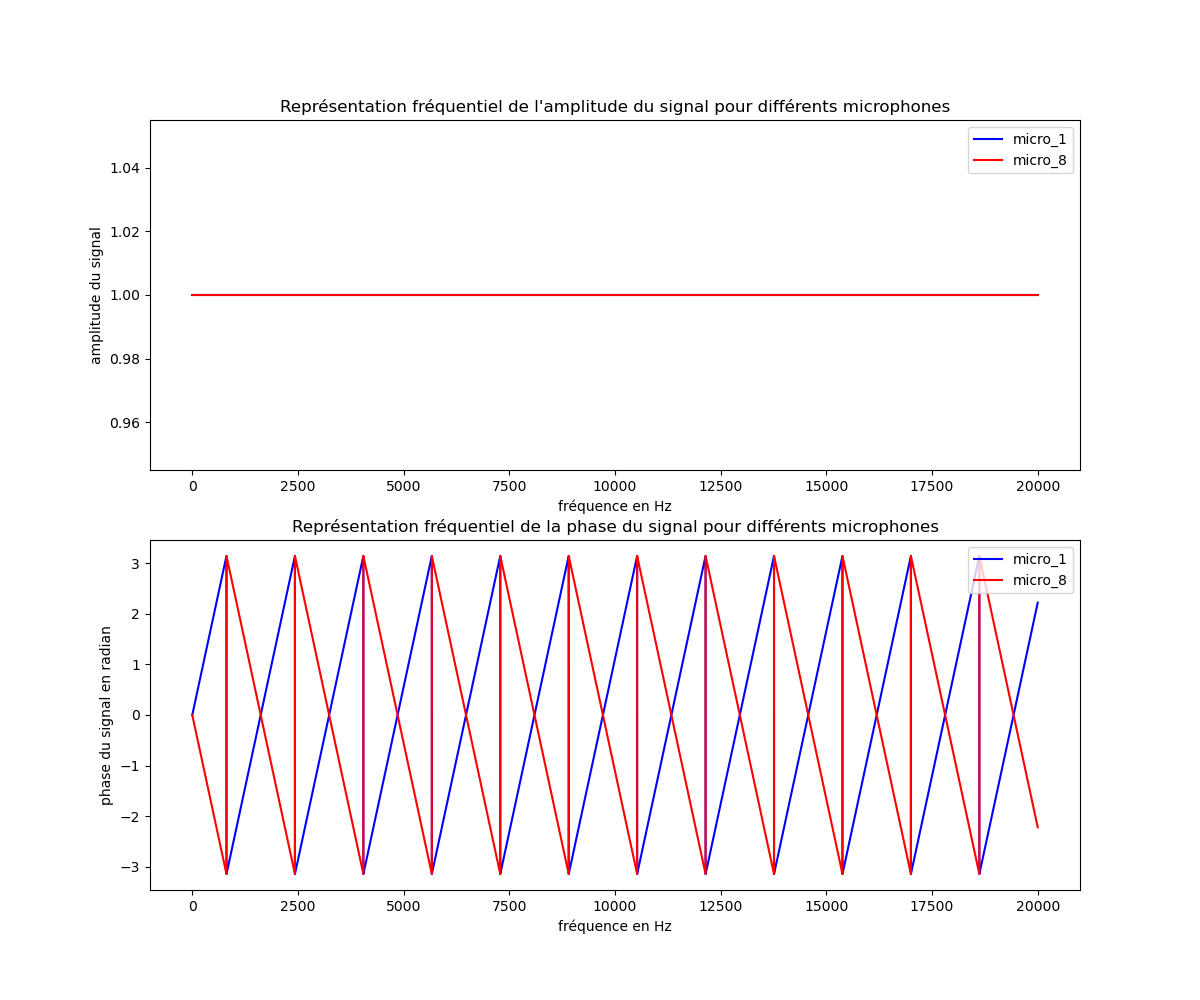

In [8]:
vect_f_p = np.linspace(0,Fs,100000)
wmic_0 = beam_filter(antenne, vect_f_p, theta0=0, mic_nb=0) # on applique le filtre pour le micro 1 avec theta0 = 0
wmic_7 = beam_filter(antenne, vect_f_p, theta0=0, mic_nb=7) # on applique le filtre pour le micro 8 avec theta0 = 0

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,10))
ax1.plot(vect_f_p,np.abs(wmic_0),color ="blue",label='micro_1')
ax1.plot(vect_f_p,np.abs(wmic_7),color ="red",label='micro_8')
ax1.set_xlabel('fréquence en Hz')
ax1.set_ylabel('amplitude du signal')
ax1.set_title("Représentation fréquentiel de l'amplitude du signal pour différents microphones")
ax1.legend(loc='upper right')
#ax1.set_xlim([freq_of_interest -50,freq_of_interest+50]) # on Zoom sur la fréquence du signal pur que l'on a envoyé 
ax2.plot(vect_f_p,np.angle(wmic_0),color ="blue",label='micro_1')
ax2.plot(vect_f_p,np.angle(wmic_7),color ="red",label='micro_8')
ax2.set_xlabel('fréquence en Hz')
ax2.set_ylabel('phase du signal en radian')
ax2.set_title("Représentation fréquentiel de la phase du signal pour différents microphones")
#ax2.set_xlim([freq_of_interest -50,freq_of_interest+50]) # on Zoom sur la fréquence du signal pur que l'on a envoyé 
ax2.legend(loc='upper right')
plt.show()



## Commentaire :
Nous observons tout d'abord que l'amplitude n'est pas modifiée. En effet, le filtre étant un déphaseur pur, il n'affecte pas l'amplitude des signaux. En revanche, pour ce qui est de la phase, nous constatons que le filtre à bien déphasé le signal entre le micro 1 et le micro 8.
En choisissant $ \theta_0 = 0 $ , le filtre est censé sélectionner les signaux alignés sur l'axe x (ie dont la propagation est parallèle au réseau) et provenant de "-x" (en référence à la figure 5 de l'énoncé). Ainsi, entre le 1er et le dernier micro, il applique un déphasage maximal de $ e^{-j*k*\frac{7}{2}} $ pour compenser le retard du signal arrivant au niveau du dernier micro qui vaut $ e^{+j*k*\frac{7}{2}} $ (et qui est le plus grand retard possible).

### 5) Compare again the filters obtained when $\theta_0 = 90^\circ$. Explain the differences.

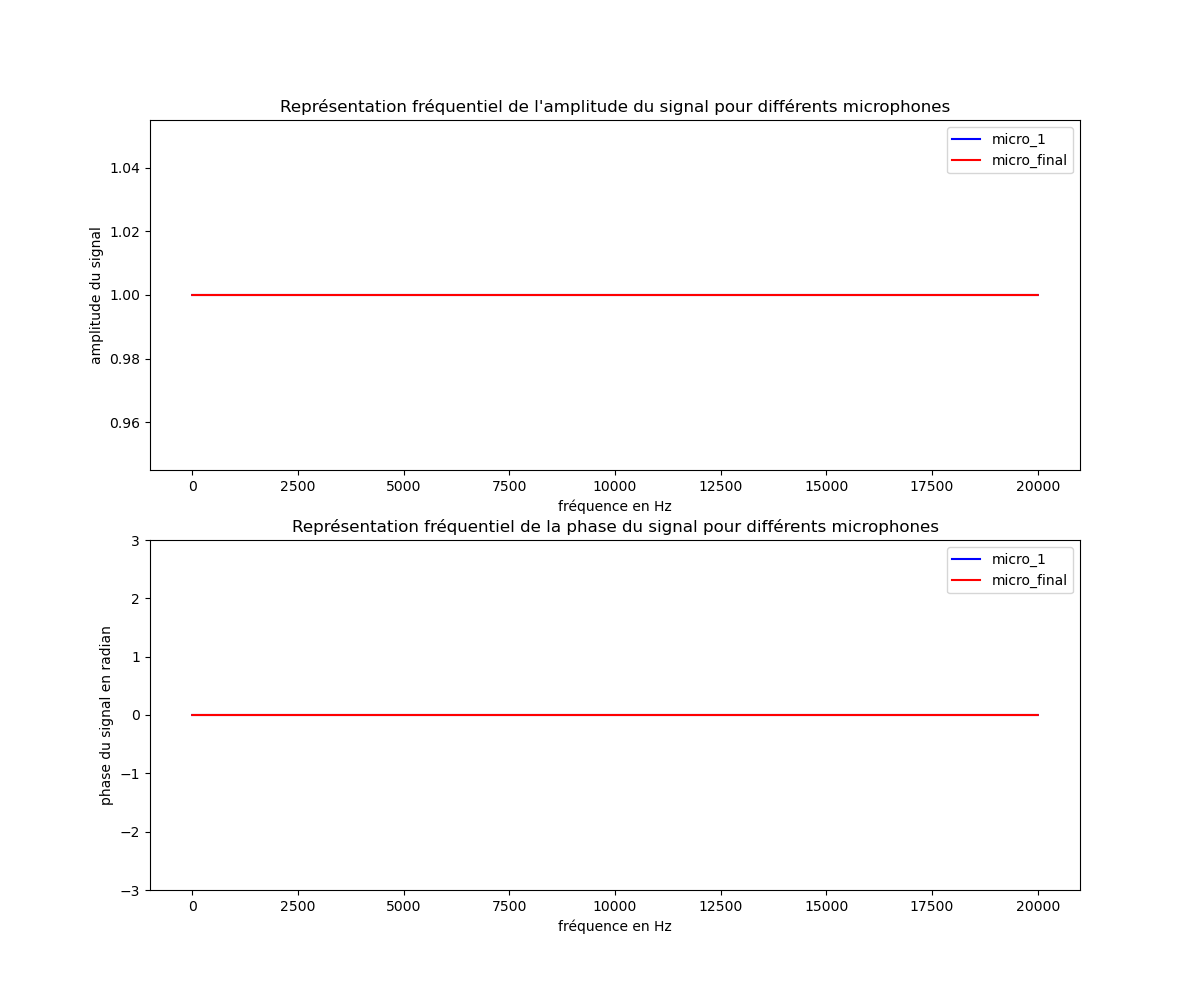

In [9]:
vect_f_p = np.linspace(0,Fs,100000)
wmic_0 = beam_filter(antenne, vect_f_p, theta0=90, mic_nb=0)
wmic_7 = beam_filter(antenne, vect_f_p, theta0=90, mic_nb=7)

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,10))
ax1.plot(vect_f_p,np.abs(wmic_0),color ="blue",label='micro_1')
ax1.plot(vect_f_p,np.abs(wmic_7),color ="red",label='micro_final')
ax1.set_xlabel('fréquence en Hz')
ax1.set_ylabel('amplitude du signal')
ax1.set_title("Représentation fréquentiel de l'amplitude du signal pour différents microphones")
ax1.legend(loc='upper right')
#ax1.set_xlim([freq_of_interest -50,freq_of_interest+50]) # on Zoom sur la fréquence du signal pur que l'on a envoyé 
ax2.plot(vect_f_p,np.angle(wmic_0),color ="blue",label='micro_1')
ax2.plot(vect_f_p,np.angle(wmic_7),color ="red",label='micro_final')
ax2.set_xlabel('fréquence en Hz')
ax2.set_ylabel('phase du signal en radian')
ax2.set_title("Représentation fréquentiel de la phase du signal pour différents microphones")
ax2.set_ylim([-3,3]) # on Zoom sur la fréquence du signal pur que l'on a envoyé 
ax2.legend(loc='upper right')
plt.show()


## Commentaire :
Lorsque $ \theta_0 = 90° $ , nous somme dans le cas où le front d'onde arrive "en face" du réseau, ie perpendiculairement à l'axe x. Dans cette situation (si l'on est bien dans le cas où la source est à l'infini et où les fronts d'onde arrivant au niveau du réseau sont plans), le signal est détecté par chaque micro en même temps, ce qui implique qu'il n'y a aucun retard, la réception se fait simultanément pour tout le réseau. Et ainsi, les filtres sont des fonctions identité. On constate en effet sur les figures ci-dessus que l'amplitude vaut 1 et la phase est nulle ce qui implique que le filtre est bien la fonction identité.

## 2.2/ Using the filters : coding of the beamforming
Basically, the beamforming algorithm is the following :

- (a) acquire an audio frame
- (b) compute the corresponding FFT
- (c) analyze the FFT to define which frequency(ies) you would like to localize
- (d) restrict the FFT to the frequencies of interest
- (e) for one given ✓ 0 , for the frequencies selected before, and for each microphone :
  — compute the corresponding filters frequency responses with the beam_filter func-
tion
  — apply these filters to the microphone outputs
- (f) compute the beamformer output associated to the angular polarization ✓ 0
- (g) repeat all these last steps for each ✓ 0 you want to test
- (h) finally, decide of the angular position of the source by detecting for which ✓ 0 the beam-
former output is maximum.

### 6) Step (a) and (b) : After acquiring an audio buffer, compute its FFT in an array $\texttt{M\_fft}$. Plot the result of this analysis as a function of the frequency when emitting a pure sine tone with a frequency $F_0 = 1$kHz.

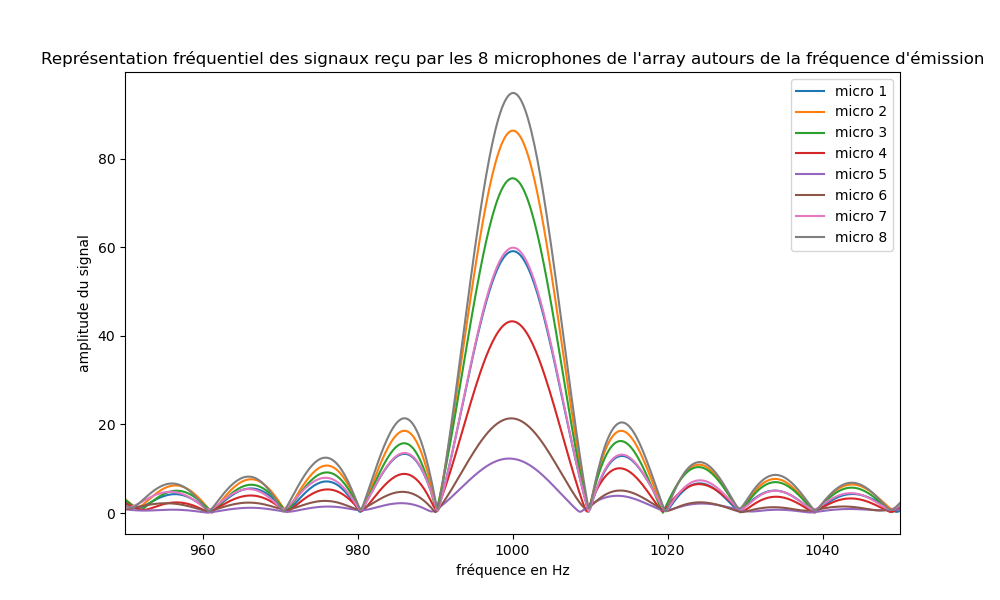

In [10]:
M_fft=[] #vecteur pour la fft de m
freqid =[] # vecteur pour récuperer les indices de fréquence max
freqval=[] # vecteur pour récuperer les valeurs de fréquence max
M=[] # vecteur pour récuperer l'amplitude à la fréquence max

freq_of_interest= 1000 #fréquence d'emission
indexf = 5*freq_of_interest # indice de la fréquence d'interêt dans le vecteur de fréquence (on multiplie par 5 car on à 5 fois plus de points à cause du zero padding


for i in range(N): 
    fft_discretem= np.fft.fft(m[:,i],100000) #on fait du zero padding pour avoir une meilleur résolution fréquentiel
    
    M_fft.append(fft_discretem)
    freqid.append(indexf-1000 + np.argmax((np.abs(M_fft[i]))[indexf-1000:indexf+1000]))  # on récupère l'indice qui correspond au maximum d'amplitude autours de la fréquence d'émission
    M.append((M_fft[i])[freqid[i]]) # On remplit les amplitudes max pour chaque micros et on garde également l'information en phase
    freqval.append(vect_f_p[freqid[i]]) # on récupère la valeur de fréquence max


fig,ax1 = plt.subplots(figsize=(10,6))
for j in range(N):
    ax1.plot(vect_f_p, np.abs(M_fft[j]), label='micro %s' % (j+1))

ax1.set_xlim([freq_of_interest - 50, freq_of_interest + 50])
ax1.legend()
ax1.set_xlabel('fréquence en Hz')
ax1.set_ylabel('amplitude du signal')
ax1.set_title("Représentation fréquentiel des signaux reçu par les 8 microphones de l'array autours de la fréquence d'émission")

plt.show()


Nous pouvons observer les différences d'amplitudes des signaux reçu par les différents microphones autours de la fréquence d'emission (1KHz). Le résultat semble étrange car la source était positionnée au centre de l'array et avec un angle $\theta_s$ de 90°, on s'attendrait donc que les microphones 4 et 5 soient ceux qui reçoivent l'amplitude maximale et les microphones 1 et 8 l'amplitude minimale.

### 7) Step (c) and (d) : Among all the frequencies you obtained from the FFT, select the one corresponding to the source frequency. Give its exact value and index $k_0$ in the frequency array, and collect the corresponding FFT values of each microphone outputs in one vector $\texttt{M}$ of length $N$.

In [11]:
print(freqid) # index k
print(freqval) #valeur de fréquence max
#print(M)

[5000, 5000, 5000, 5000, 4998, 4999, 5000, 5000]
[1000.0100001000011, 1000.0100001000011, 1000.0100001000011, 1000.0100001000011, 999.609996099961, 999.809998099981, 1000.0100001000011, 1000.0100001000011]


on remarque que pour les 8 micros, on a bien des valeurs de fréquence pour lesquelles l'amplitude maximal est très proche de la fréquence d'émission de la source

### 8) Step (e) : In a loop among all microphones, compute each filters for the position $\theta_0$ and for the frequency value you obtained in the previous step. Apply then these filters to the array $\texttt{M}$ defined before.

In [12]:
S=[]
for k in range(N):
    wmic = beam_filter(antenne, freqval[k], theta0=140, mic_nb=k) # on calcul le filtre en fréquentiel pour un theta 0 fixé 
    Mk=M[k]
    S.append(Mk*wmic)  # la sortie correspond à la multiplication en fréquentiel de M et du filtre
    

### 9) \textbf{Step (f):} Combine then the filters outputs to form the beamformer output $Y_{\theta_0}[k_0]$. *$Y_{\theta_0}[k_0]$ is obviously a complex value which corresponds to the frequency contribution of the source to the $k_0^{\text{th}}$ frequency component of the beamformer output when focalized in the direction $\theta_0$.* Compute then the corresponding power $P(\theta_0)$ at $k_0$ of the beamformer output.

In [13]:
Y = np.sum(S) # on somme toute les sorties pour avoir la réponse globale
P = np.abs(Y)**2  # on peut calculer la puissance moyenne du signal 
print(P)

18052.133575260224


Cette puissance va nous permettre, une fois calculée pour tous les angles $\theta_s$ entre 0 et 180, d'avoir une sorte de carte d'énérgie indiquant la polarisation de notre signal d'origine et on pourra donc localiser la position de la source en regardant le max d'énérgie sur cette carte.

### 10) For a direction $\theta_0$ of your choice, compute $P(\theta_0)$ for (i) a source emitting from a direction close to $\theta_0$, or (ii) far from it. Compare the two values.

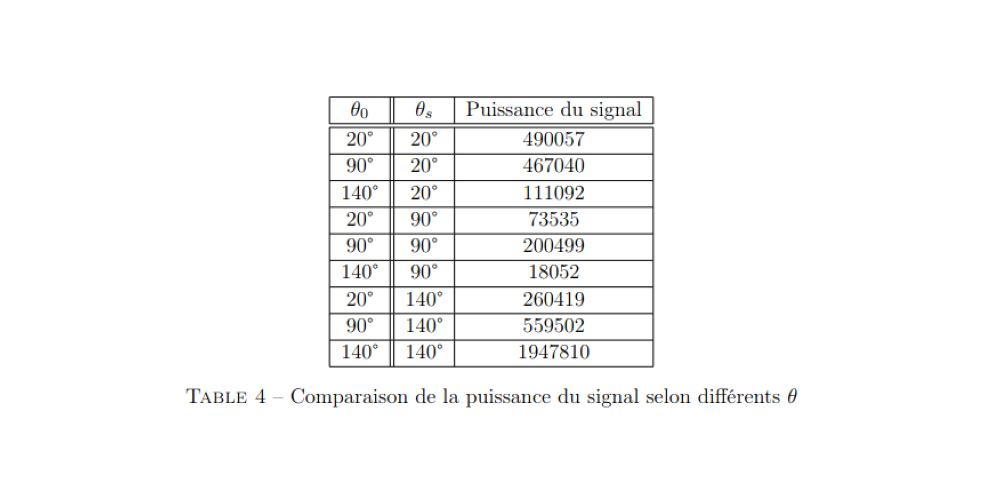

In [15]:
# on charge les figures 
Table1 = mpimg.imread('./img/Table_1.png')
# Create a new figure and plot the loaded figures
fig, ax4= plt.subplots(1,figsize=(10,5))

# Plot the first figure on the top-left subplot
ax4.imshow(Table1)
ax4.axis('off')  # Turn off the axis labels
plt.show()

On voit bien que la puissance est maximal lorsque, pour une même distance à la source, l'angle de polarisation $\theta_0$ est proche de l'angle de décalage de la source $\theta_s$ par rapport à l'array et inversement. C'est précisement cette logique que l'on va ensuite utiliser pour la localisation de source.

### 11) Step (g) : Repeat now the previous code in a loop for $\theta_0$ values ranging from 0 to 180° .You should then obtain an array $\texttt{P}$ where each value corresponds to the power of the beamformer output at $F_0$ for each angular polarization. Plot the array $\texttt{P}$ as a function of the angle $\theta_0$.

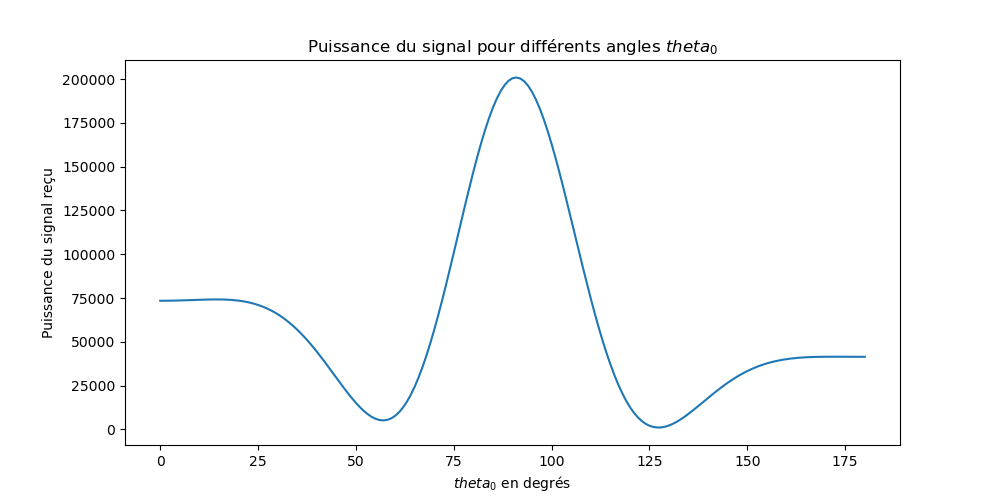

In [16]:
P_buffer=[]
for l in range(0,181,1):
    S=[]
    for k in range(N): # on fait la même chose que précédement mais pour des valeurs de théta qui vont de 0 à 180
        wmic = beam_filter(antenne, freqval[k], theta0=l, mic_nb=k)
        Mk=M[k]
        S.append(Mk*wmic)
    Y = np.sum(S)
    P = np.abs(Y)**2
    P_buffer.append(P)

vect_P = np.linspace(0, 180, 181)
fig, ax3 = plt.subplots(1,figsize=(10,5))
ax3.plot(vect_P,P_buffer)
ax3.set_ylabel('Puissance du signal reçu')
ax3.set_xlabel('$theta_0$ en degrés')
ax3.set_title("Puissance du signal pour différents angles $theta_0$")
plt.show()
    

La source ayant été placée a une distance supérieur à la longueur de l'array pour simuler l'hypothèse d'onde plane et avec un angle $\theta_s = 90°$, le résultat est plutôt satisfaisant puisque notre maximum en puissance semble se situer autours de cette valeur. On notera que le lobe principal est plutôt large, on est donc pas très séléctif dans notre polarisation.

### 12) Step (h) : Find the $\theta_0$ value corresponding to position of the maximum in $\texttt{P}$ and compare it with the actual (but approximate) position of the sound source.

In [17]:
thetmax= vect_P[np.argmax(P_buffer)] # on prend l'angle qui correspond au maximu de notre valeur de puissance
print(thetmax)


91.0


On est donc réelement très proche de la valeurs que nous avions estimé de $\theta_s$ lors de l'aquisition. Cependant, sans dispositif précis pour avoir la valeur réelle de $\theta_s$, il est difficile de réelement qualifier la qualité des résultats (il est possible que nous n'ayons pas vraiment placer la source à $\theta_s = 90°$ et que l'erreur soit donc grande en réalité 

## 2.3/ Analyzing the beamformer performances

From now on, you can use your own code written in Section 2.2, or use the provided beamformer function which exactly reproduces the beamformer algorithm. You might then add $\texttt{from beamformer\_etu import beamformer}$ in your Notebook before being able to use the beamformer function.

### 13) Plot the energy maps you obtain when using source frequencies $F_0 = 400$Hz, $F_0 = 1$kHz, $F_0 = 2$kHz and $F_0 = 4$kHz emitting from a fixed arbitrary position. Comment and explain carefully the differences between these curves

In [18]:
'''F0 = 1000  # cellule qui nous a permis d'avoir les résultats ci-dessous
vect_P = np.linspace(0, 180, 181)
b = beamformer(m, vect_P, F0, Fs)

fig, ax = plt.subplots()

ax.plot(vect_P, b)

ax.set_title("Carte énergétique pour F0 = 400 Hz et theta à environ 90 °")
ax.set_xlabel("theta en degré")
ax.set_ylabel("Energie du signal")
plt.show()'''

'F0 = 1000  # cellule qui nous a permis d\'avoir les résultats ci-dessous\nvect_P = np.linspace(0, 180, 181)\nb = beamformer(m, vect_P, F0, Fs)\n\nfig, ax = plt.subplots()\n\nax.plot(vect_P, b)\n\nax.set_title("Carte énergétique pour F0 = 400 Hz et theta à environ 90 °")\nax.set_xlabel("theta en degré")\nax.set_ylabel("Energie du signal")\nplt.show()'

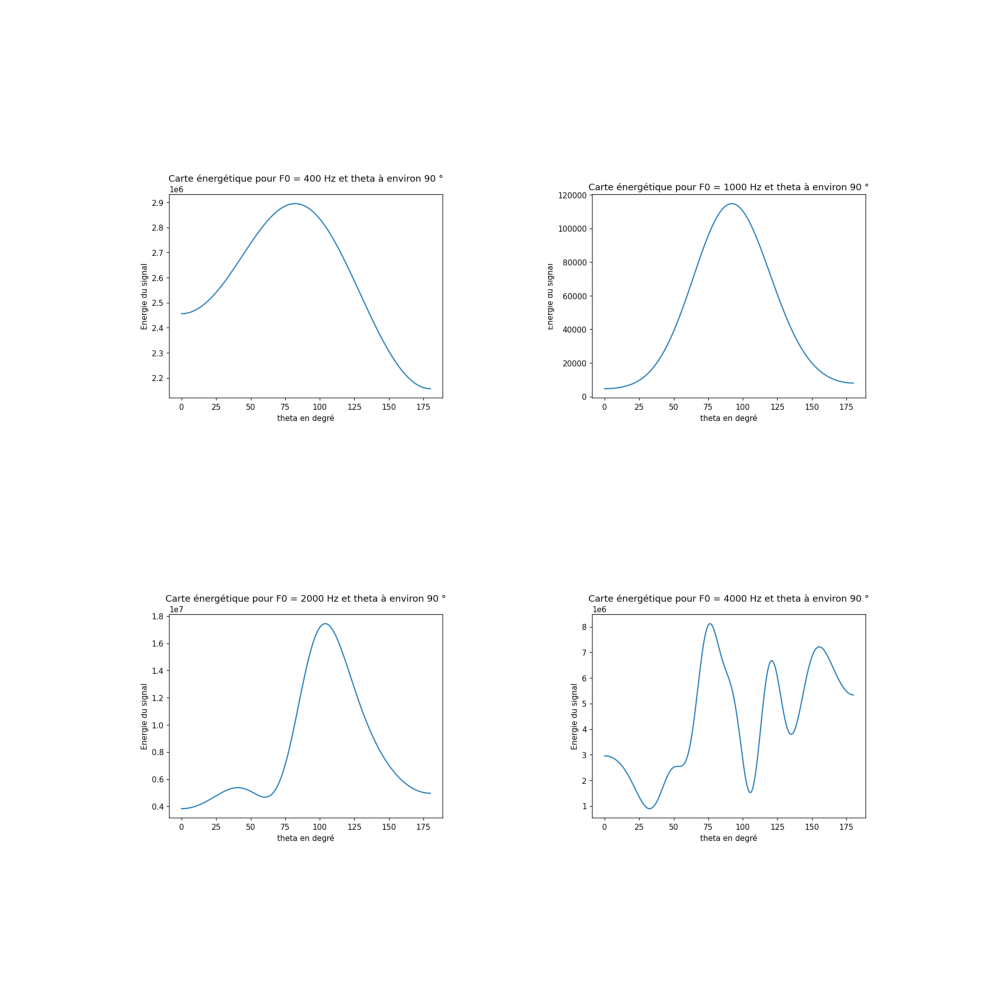

In [20]:
# on charge les figures 
figure1 = mpimg.imread('./img/400Hz_q13.png')
figure2 = mpimg.imread('./img/1000Hz_q13.png')
figure3 = mpimg.imread('./img/2000Hz_q13.png')
figure4 = mpimg.imread('./img/4000Hz_q13.png')

# Create a new figure and plot the loaded figures
fig, ax = plt.subplots(2, 2,figsize=(10,10))  # Create a figure with 1 row and 2 columns

# Plot the first figure on the top-left subplot
ax[0, 0].imshow(figure1)
ax[0, 0].axis('off')  # Turn off the axis labels

# Plot the second figure on the top-right subplot
ax[0, 1].imshow(figure2)
ax[0, 1].axis('off')  # Turn off the axis labels

# Plot the third figure on the bottom-left subplot
ax[1, 0].imshow(figure3)
ax[1, 0].axis('off')  # Turn off the axis labels

# Plot the fourth figure on the bottom-right subplot
ax[1, 1].imshow(figure4)
ax[1, 1].axis('off')  # Turn off the axis labels

# Show the plot
plt.show()



On peut comparer la largeur du lobe principal (qualitativement) en regardant quelle bande de $\theta$ est couverte par celui-ci.
Ainsi, on retrouve les remarques théoriques du cours avec une selectivité spatiale plus faible pour les basses fréquence.
Avec les résultats du TP1, on avait conclu que Fmax valait environ 400Hz, donc on dela de cette valeur, on peut commencer à voir des phénomène de recouvrement qui explique donc surement pourquoi, pour 2000 et 4000 Hz, on commence à avoir des formes plus ambigus.

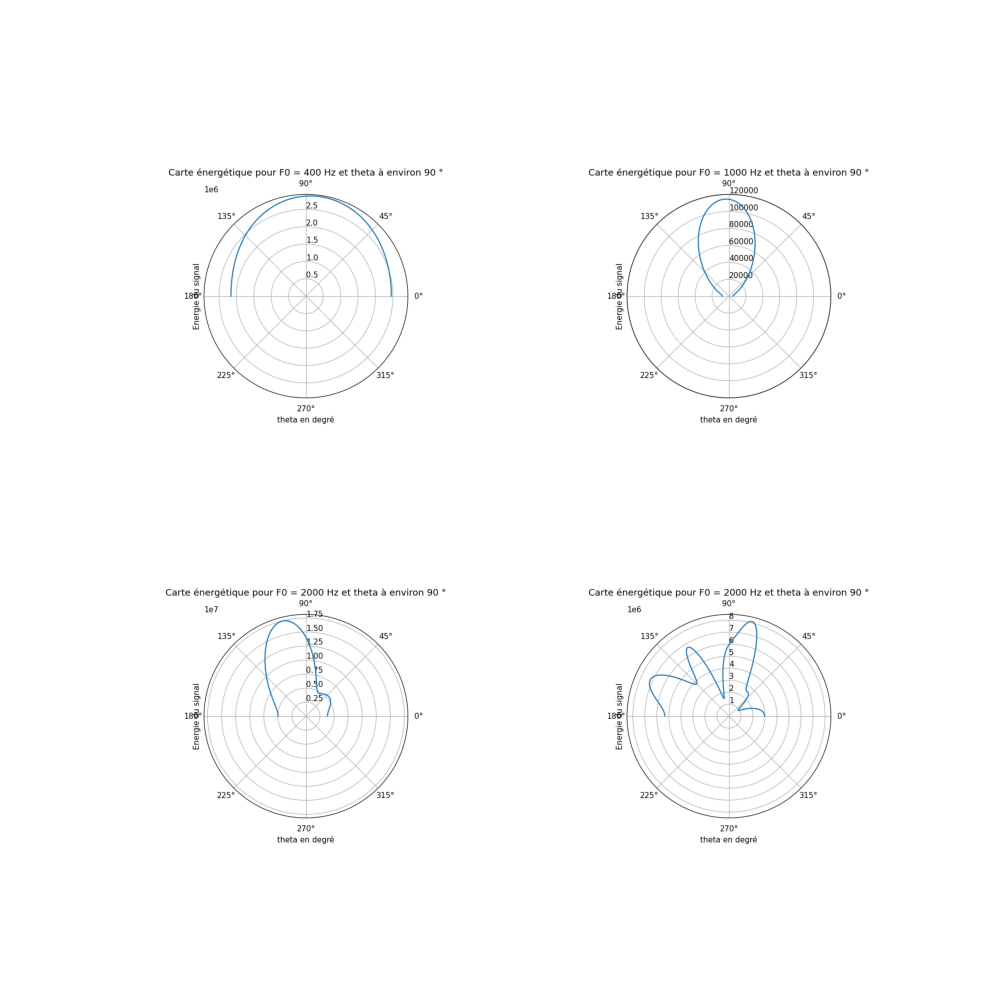

In [21]:
# on charge les figures 
figure1 = mpimg.imread('./img/400Hz_q13_pol.png')
figure2 = mpimg.imread('./img/1000Hz_q13_pol.png')
figure3 = mpimg.imread('./img/2000Hz_q13_pol.png')
figure4 = mpimg.imread('./img/4000Hz_q13_pol.png')

# Create a new figure and plot the loaded figures
fig, ax = plt.subplots(2, 2,figsize=(10,10))  # Create a figure with 1 row and 2 columns

# Plot the first figure on the top-left subplot
ax[0, 0].imshow(figure1)
ax[0, 0].axis('off')  # Turn off the axis labels

# Plot the second figure on the top-right subplot
ax[0, 1].imshow(figure2)
ax[0, 1].axis('off')  # Turn off the axis labels

# Plot the third figure on the bottom-left subplot
ax[1, 0].imshow(figure3)
ax[1, 0].axis('off')  # Turn off the axis labels

# Plot the fourth figure on the bottom-right subplot
ax[1, 1].imshow(figure4)
ax[1, 1].axis('off')  # Turn off the axis labels

# Show the plot
plt.show()

Représentation polaire pour mieux visualiser la carte d'énérgie, on arrive aux mêmes conclusions sur la séléctivité et le potentiel recouvrement.

### 14) For a frequency $F_0 = 1$kHz and a source moving aroud the array, plot the estimated position as a function of time. Comment the effectiveness of the approach and its limits.

In [ ]:
'''F0 = 1000  # on récupère le maximum en puissance pour chaque signal 
vect_P = np.linspace(0, 180, 181)
b = beamformer(m, vect_P, F0, Fs)
thetmax= vect_P[np.argmax(b)]  # on estime l'angle de la source par rapport à l'array
print(thetmax)'''



In [ ]:
'''Pos_list_ref=[99,128,92,120,112] #test avec la fonction de référence
Pos_list_etu=[23,107,91,104,100]  # test avec notre function beamformer
time=[1,2,3,4,5]

theta_rad = np.radians(Pos_list)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.plot(theta_rad, time, marker='o')

ax.set_title("Evolution de l'angle theta en fonction du temps")
ax.set_rlabel_position(90)  # Set radial labels at 90 degrees
ax.set_theta_direction(-1)  # Change theta direction to clockwise (optional)
ax.set_theta_offset(np.pi/2)  # Adjust the starting angle (optional)

# Show the polar plot
plt.show()'''


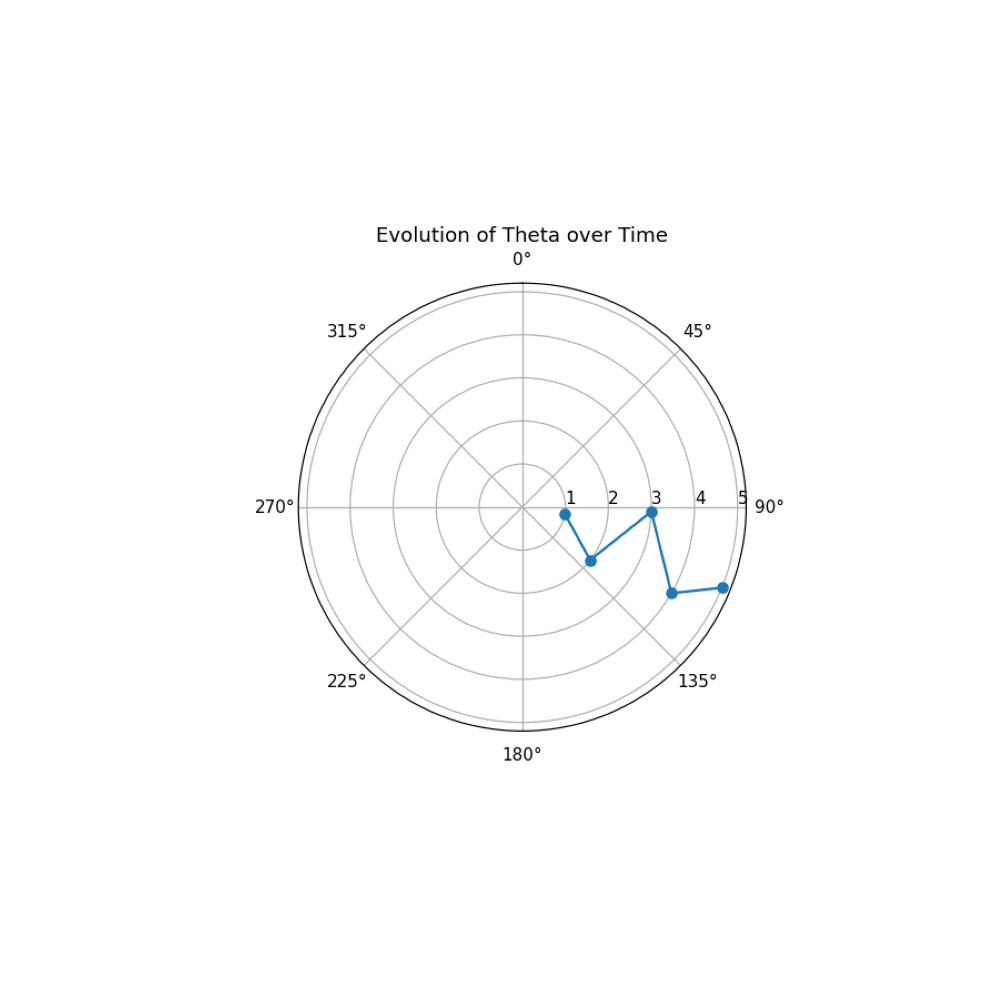

In [22]:
# on charge les figures 
figure5 = mpimg.imread('./img/Theta_over_time.png')
# Create a new figure and plot the loaded figures
fig, ax = plt.subplots(1,figsize=(10,10))

# Plot the first figure on the top-left subplot
ax.imshow(figure5)
ax.axis('off')  # Turn off the axis labels
plt.show()

Some comments